83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Analyzing Image...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_46']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Heatmap saved as 'gradcam_result.jpg'


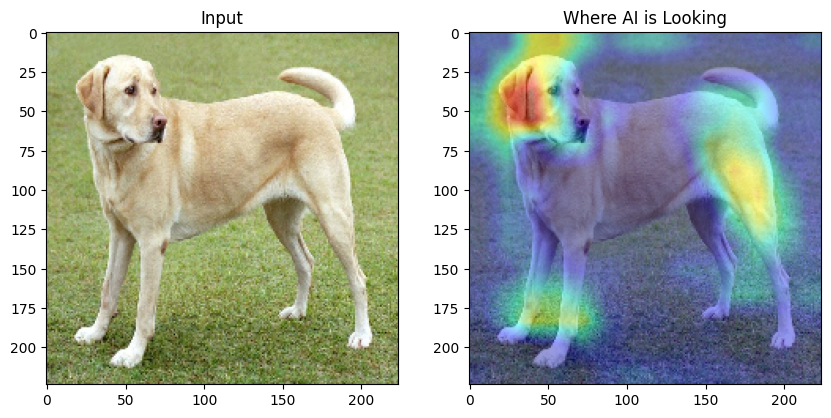

In [3]:
# --- ONE-CELL PROJECT: EXPLAINABLE AI (Grad-CAM) ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Load Pre-trained VGG16 (The "Doctor")
model = tf.keras.applications.VGG16(weights='imagenet')

# 2. Get a Sample Image (Fixed URL: Yellow Labrador hosted by Google)
# We use this URL because Wikipedia blocks automated downloads (Error 403)
img_path = tf.keras.utils.get_file(
    'labrador.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
)

def get_gradcam_heatmap(model, img_path, layer_name='block5_conv3'):
    # Prepare Image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    # VGG16 expects specific preprocessing
    img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_batch.copy())

    # Build a model that maps Input -> (Last Conv Layer, Predictions)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Compute Gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_preprocessed)
        # Get the loss for the highest predicted class
        loss = predictions[:, np.argmax(predictions[0])]

    # Calculate gradient of the loss with respect to the feature map
    grads = tape.gradient(loss, conv_outputs)
    # Global Average Pooling to get the "importance weights"
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply filters by importance to create the heatmap
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), img_array

# 3. Generate Heatmap
print("Analyzing Image...")
heatmap, original_img = get_gradcam_heatmap(model, img_path)

# 4. Overlay Heatmap
# Resize heatmap to match image size
heatmap_resized = cv2.resize(heatmap, (224, 224))
# Convert heatmap to RGB colors (OpenCV uses BGR by default, so we adjust)
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

# Superimpose
superimposed = cv2.addWeighted(original_img.astype('uint8'), 0.6, heatmap_colored, 0.4, 0)

# 5. Save & Show
# Save as BGR (because cv2.imwrite expects BGR)
cv2.imwrite("gradcam_result.jpg", cv2.cvtColor(superimposed, cv2.COLOR_RGB2BGR))
print("✅ Heatmap saved as 'gradcam_result.jpg'")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(original_img.astype('uint8')/255); plt.title("Input")
plt.subplot(1,2,2); plt.imshow(superimposed); plt.title("Where AI is Looking")
plt.show()